# 3MARKOWITZ: OPTIMIZACIÓN CLÁSICA DE MARKOWITZ

Este notebook demuestra el funcionamiento del módulo 3markowitz, que implementa las técnicas clásicas de optimización de carteras basadas en la teoría de Markowitz.

**Conexión con módulos anteriores**: Este módulo utiliza los insights de diversificación del módulo `2equiponderada_diversificacion` para optimizar carteras considerando el trade-off riesgo-rendimiento. Mientras que el módulo 2 analiza carteras equiponderadas para entender el efecto de diversificación, este módulo encuentra las ponderaciones exactas que maximizan el rendimiento ajustado por riesgo, utilizando la misma matriz de covarianza (Σ) y los mismos principios teóricos de diversificación.

In [11]:
import sys
import importlib
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importar módulos (los nombres que empiezan con números requieren importlib)
datos = importlib.import_module('1datos')
markowitz = importlib.import_module('3markowitz')

print("Librerías importadas correctamente")

Librerías importadas correctamente


## Paso 1: Cargar y preparar datos

In [12]:
ruta_csv = '../data/prod_long_sharpe_u50_20260116_v5_train_dataset.csv'
retornos = datos.cargar_retornos(ruta_csv)

preparador = datos.PreparadorDatos(retornos, rf_anual=0.02)
preparador.calcular_estadisticas()
mu, Sigma, rf = preparador.obtener_estadisticas()

print(f"Datos preparados: μ shape {mu.shape}, Σ shape {Sigma.shape}, rf = {rf:.4f}")

Datos cargados: 1760 días, 50 activos
Datos preparados: μ shape (50,), Σ shape (50, 50), rf = 0.0200


## Paso 2: Optimización Markowitz con diferentes λ

In [13]:
lambdas = [0.5, 1.0, 2.0, 5.0]
resultados_lambda = []

for lam in lambdas:
    res = markowitz.optimizar_markowitz_lambda(mu, Sigma, rf, lam)
    if res:
        resultados_lambda.append({
            'lambda': lam,
            'sharpe': res['sharpe'],
            'rentabilidad': res['rentabilidad'],
            'volatilidad': res['volatilidad']
        })
        print(f"λ={lam}: Sharpe={res['sharpe']:.4f}, Ret={res['rentabilidad']*100:.2f}%, Vol={res['volatilidad']*100:.2f}%")

df_lambda = pd.DataFrame(resultados_lambda)
print("\nResumen:")
print(df_lambda)

λ=0.5: Sharpe=1.0190, Ret=17.69%, Vol=15.40%
λ=1.0: Sharpe=1.0190, Ret=17.69%, Vol=15.40%
λ=2.0: Sharpe=1.0722, Ret=16.94%, Vol=13.94%
λ=5.0: Sharpe=1.1614, Ret=14.74%, Vol=10.97%

Resumen:
   lambda    sharpe  rentabilidad  volatilidad
0     0.5  1.018979      0.176903     0.153981
1     1.0  1.018979      0.176903     0.153981
2     2.0  1.072240      0.169443     0.139374
3     5.0  1.161445      0.147413     0.109702


## Paso 3: Optimización de Máximo Sharpe

In [14]:
cartera_max_sharpe = markowitz.optimizar_sharpe_maximo(mu, Sigma, rf)

if cartera_max_sharpe:
    print("Cartera de Máximo Sharpe:")
    print(f"  Sharpe Ratio: {cartera_max_sharpe['sharpe']:.4f}")
    print(f"  Rentabilidad: {cartera_max_sharpe['rentabilidad']*100:.2f}%")
    print(f"  Volatilidad: {cartera_max_sharpe['volatilidad']*100:.2f}%")
    print(f"  Peso en RF: {cartera_max_sharpe['w_rf']*100:.2f}%")
    print(f"  Número de activos con peso >1%: {np.sum(cartera_max_sharpe['w'] > 0.01)}")

Cartera de Máximo Sharpe:
  Sharpe Ratio: 0.0420
  Rentabilidad: 2.40%
  Volatilidad: 9.42%
  Peso en RF: 10.00%
  Número de activos con peso >1%: 45


In [15]:
## Paso 3.1: Vector de Pesos de la Cartera de Máximo Sharpe

if cartera_max_sharpe:
    # Obtener nombres de activos en orden
    nombres_activos = [f'asset{i+1}' for i in range(len(cartera_max_sharpe['w']))]
    
    # Vector de pesos en orden (asset1, asset2, ..., asset50)
    # Redondear a 3 decimales
    pesos = np.round(cartera_max_sharpe['w'], 3)
    w_rf_redondeado = round(cartera_max_sharpe['w_rf'], 3)
    
    # Mostrar vector de pesos separado por comas (máximo 3 decimales)
    print("=" * 80)
    print("VECTOR DE PESOS DE LA CARTERA DE MÁXIMO SHARPE")
    print("=" * 80)
    print("\nPesos de los 50 activos (en orden asset1, asset2, ..., asset50):")
    print(",".join([f"{w:.3f}" for w in pesos]))
    print(f"\nPeso destinado a Renta Fija (RF): {w_rf_redondeado:.3f}")
    print(f"Total (debe sumar 1.0): {np.sum(pesos) + w_rf_redondeado:.3f}")
    
    # Crear tabla con distribución de pesos (redondeados a 3 decimales)
    print("\n" + "=" * 80)
    print("DISTRIBUCIÓN DE PESOS POR ACTIVO")
    print("=" * 80)
    
    df_pesos = pd.DataFrame({
        'Activo': nombres_activos,
        'Peso': pesos,
        'Peso (%)': (pesos * 100).round(2)  # Porcentajes con 2 decimales
    })
    
    # Ordenar por peso descendente para mejor visualización
    df_pesos = df_pesos.sort_values('Peso', ascending=False).reset_index(drop=True)
    
    # Formatear la tabla para mostrar 3 decimales en Peso
    print("\nTabla completa de pesos:")
    # Crear copia para formatear sin modificar el original
    df_display = df_pesos.copy()
    df_display['Peso'] = df_display['Peso'].apply(lambda x: f"{x:.3f}")
    print(df_display.to_string(index=False))
    
    # Mostrar solo activos con peso > 0.0001 (0.01%)
    print("\n" + "-" * 80)
    print("Activos con peso significativo (>0.01%):")
    print("-" * 80)
    df_significativos = df_pesos[df_pesos['Peso'] > 0.0001].copy()
    df_significativos['Peso'] = df_significativos['Peso'].apply(lambda x: f"{x:.3f}")
    print(df_significativos.to_string(index=False))
    
    # Resumen de renta fija
    print("\n" + "=" * 80)
    print("RESUMEN DE RENTA FIJA")
    print("=" * 80)
    print(f"Peso en Renta Fija: {w_rf_redondeado:.3f} ({w_rf_redondeado*100:.2f}%)")
    print(f"Peso en Activos Riesgosos: {np.sum(pesos):.3f} ({np.sum(pesos)*100:.2f}%)")

VECTOR DE PESOS DE LA CARTERA DE MÁXIMO SHARPE

Pesos de los 50 activos (en orden asset1, asset2, ..., asset50):
0.009,0.015,0.019,0.017,0.027,0.012,0.010,0.017,0.016,0.014,0.034,0.017,0.015,0.015,0.016,0.016,0.008,0.025,0.016,0.040,0.008,0.018,0.014,0.018,0.030,0.017,0.012,0.018,0.016,0.011,0.013,0.012,0.019,0.025,0.024,0.002,0.021,0.010,0.017,0.017,0.013,0.027,0.017,0.019,0.040,0.021,0.008,0.013,0.031,0.029

Peso destinado a Renta Fija (RF): 0.100
Total (debe sumar 1.0): 0.998

DISTRIBUCIÓN DE PESOS POR ACTIVO

Tabla completa de pesos:
 Activo  Peso  Peso (%)
asset45 0.040       4.0
asset20 0.040       4.0
asset11 0.034       3.4
asset49 0.031       3.1
asset25 0.030       3.0
asset50 0.029       2.9
asset42 0.027       2.7
 asset5 0.027       2.7
asset18 0.025       2.5
asset34 0.025       2.5
asset35 0.024       2.4
asset46 0.021       2.1
asset37 0.021       2.1
 asset3 0.019       1.9
asset33 0.019       1.9
asset44 0.019       1.9
asset28 0.018       1.8
asset24 0.018       1.8


## Paso 4: Visualizar distribución de pesos

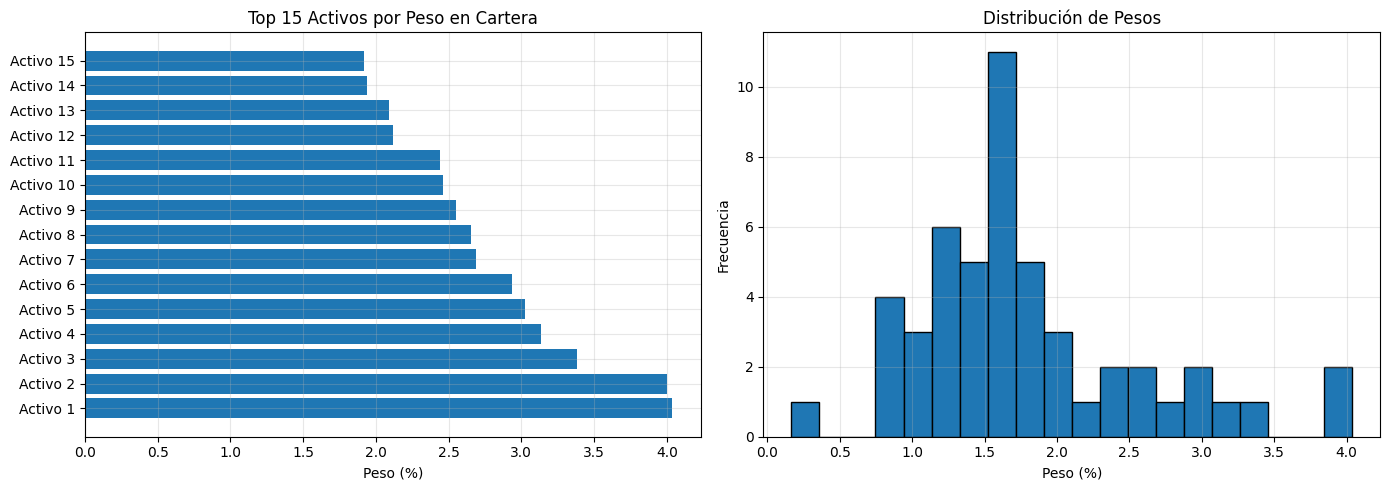

In [16]:
if cartera_max_sharpe:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Top 15 activos por peso
    w_sorted = np.sort(cartera_max_sharpe['w'])[::-1]
    top15 = w_sorted[:15]
    
    axes[0].barh(range(len(top15)), top15 * 100)
    axes[0].set_yticks(range(len(top15)))
    axes[0].set_yticklabels([f'Activo {i+1}' for i in range(len(top15))])
    axes[0].set_xlabel('Peso (%)')
    axes[0].set_title('Top 15 Activos por Peso en Cartera')
    axes[0].grid(True, alpha=0.3)
    
    # Distribución de pesos
    axes[1].hist(cartera_max_sharpe['w'] * 100, bins=20, edgecolor='black')
    axes[1].set_xlabel('Peso (%)')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribución de Pesos')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('outputs/modulo2_pesos.png', dpi=300, bbox_inches='tight')
    plt.show()

## Paso 5: Construir Frontera Eficiente

In [20]:
frontera_df = markowitz.construir_frontera_eficiente(mu, Sigma, rf, n_puntos=50)

print(f"Frontera eficiente construida con {len(frontera_df)} puntos")
print(f"  Sharpe máximo en frontera: {frontera_df['sharpe'].max():.4f}")
print(f"  Rentabilidad máxima: {frontera_df['rentabilidad'].max()*100:.2f}%")
print(f"  Volatilidad mínima: {frontera_df['volatilidad'].min()*100:.2f}%")

Frontera eficiente construida con 50 puntos
  Sharpe máximo en frontera: 1.1617
  Rentabilidad máxima: 16.81%
  Volatilidad mínima: 6.51%


## Paso 6: Visualizar Frontera Eficiente

Max Sharpe en frontera: 1.1617


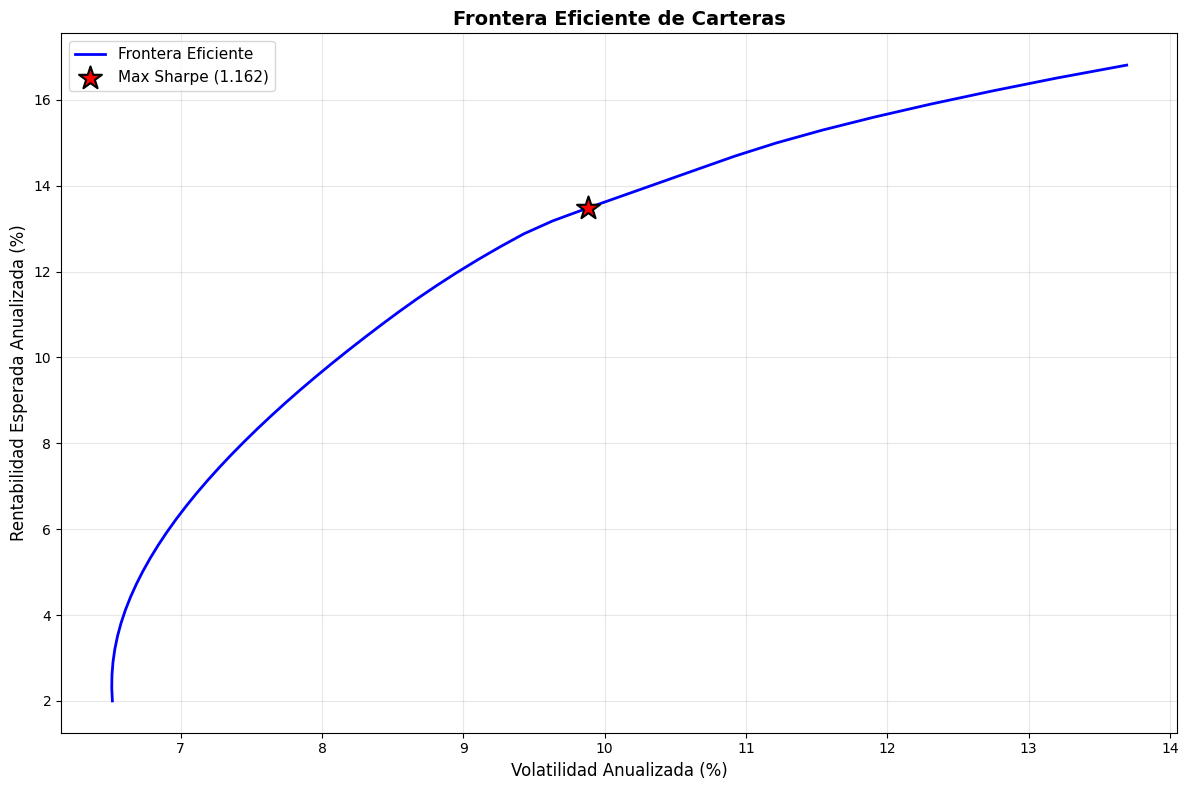

In [21]:
# Nota: optimizar_sharpe_maximo aplica un cap de w_rf post-normalización.
# Para garantizar coherencia de restricciones con la frontera, tomamos el máximo Sharpe desde la frontera misma.
if 'frontera_df' not in globals():
    # Si se ejecuta esta celda sin haber construido la frontera, la reconstruimos con los mismos parámetros.
    frontera_df = markowitz.construir_frontera_eficiente(mu, Sigma, rf, n_puntos=50)

max_sharpe_row = frontera_df.loc[frontera_df['sharpe'].idxmax()]

cartera_max_sharpe_frontera = {
    'sharpe': max_sharpe_row['sharpe'],
    'rentabilidad': max_sharpe_row['rentabilidad'],
    'volatilidad': max_sharpe_row['volatilidad']
}

# Validación básica: el máximo Sharpe está exactamente en la frontera construida
print(f"Max Sharpe en frontera: {cartera_max_sharpe_frontera['sharpe']:.4f}")

fig = markowitz.visualizar_frontera_eficiente(
    frontera_df,
    cartera_max_sharpe_frontera,
    ruta_guardado='outputs/modulo2_frontera.png'
)
plt.show()

## Paso 7: Análisis de Sensibilidad Temporal

Análisis de Sensibilidad Temporal:
    ventana    sharpe  rentabilidad  volatilidad  concentracion  n_activos  \
0      252d  1.793022      0.148674     0.071764       0.024680         41   
1      504d -0.006722      0.019419     0.086359       0.020060         47   
2      756d  0.666816      0.067826     0.071723       0.058842         38   
3  Completa  0.041961      0.023954     0.094237       0.019282         45   

   peso_rf  
0      0.1  
1      0.1  
2      0.1  
3      0.1  


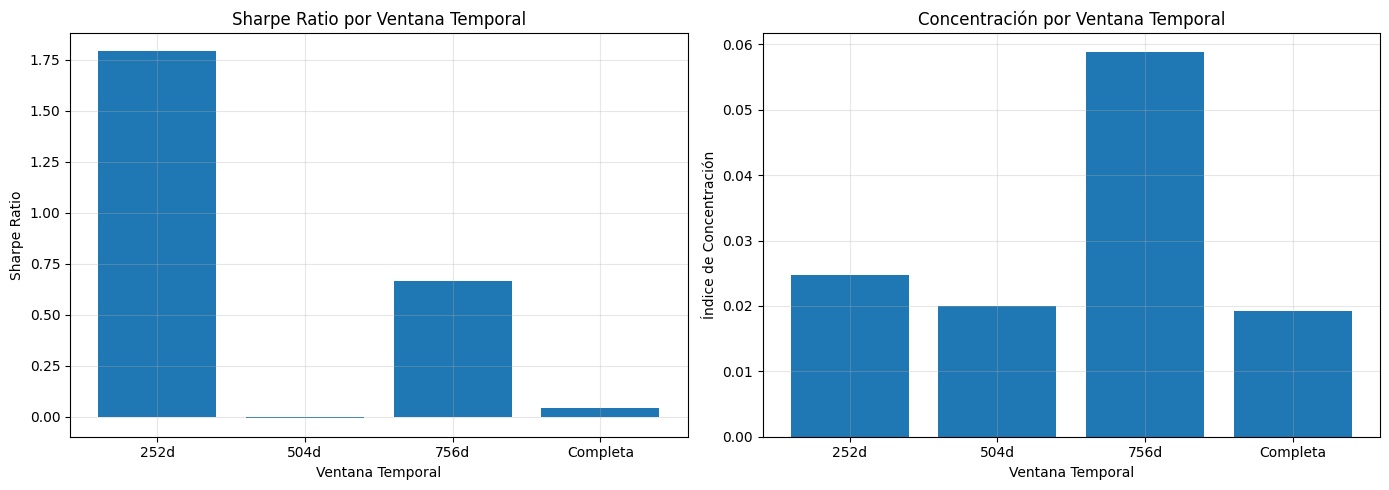

In [22]:
sensibilidad = markowitz.analizar_sensibilidad_temporal(retornos, rf, ventanas=[252, 504, 756, None])

print("Análisis de Sensibilidad Temporal:")
print(sensibilidad)

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(sensibilidad['ventana'], sensibilidad['sharpe'])
axes[0].set_xlabel('Ventana Temporal')
axes[0].set_ylabel('Sharpe Ratio')
axes[0].set_title('Sharpe Ratio por Ventana Temporal')
axes[0].grid(True, alpha=0.3)

axes[1].bar(sensibilidad['ventana'], sensibilidad['concentracion'])
axes[1].set_xlabel('Ventana Temporal')
axes[1].set_ylabel('Índice de Concentración')
axes[1].set_title('Concentración por Ventana Temporal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/modulo2_sensibilidad.png', dpi=300, bbox_inches='tight')
plt.show()

## Resumen del módulo 3markowitz

El módulo 2markowitz ha completado exitosamente:

1. Optimización de Markowitz con diferentes parámetros λ
2. Optimización directa del Sharpe Ratio máximo
3. Construcción de la frontera eficiente
4. Análisis de sensibilidad temporal

La cartera de máximo Sharpe está lista para ser comparada con estrategias multifactoriales en los siguientes módulos.